# Modelagem Sarima para Precipitação Mensal na Cidade de São Paulo

In [3]:
from dateutil.parser import parse 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import mplcursors
from datetime import datetime

from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
 
import warnings
warnings.filterwarnings("ignore")

Matplotlib created a temporary config/cache directory at C:\Users\MATHEU~1\AppData\Local\Temp\matplotlib-zpz52f68 because the default path (C:\Users\Matheus Alves\.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Leitura do Arquivo Original - Precipitação em $m m$ por mês - Base BDMEP

Importante notar que os dados foram pré-tratados através do Excel, foi realiazada uma junção entre bases automáticas e manuais, visto que a literatura indicou que não haveria mudança significativa de precipitação total entre as bases.

In [4]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [5]:
#Lendo os Dados
rainfall = pd.read_csv(r"C:\Users\Matheus Alves\Documents\git_tcc\time_series_precipitation\Dataset\dados_chuvas1.csv",parse_dates=[0], index_col=0, date_parser=parser)

In [6]:
#Amostra da Base (5 primeiros[antigos] e os 5 últimos[recentes] valores)
rainfall

,Precipitation
Date,
1984-01-31,259.3
1984-02-29,32.5
1984-03-31,54.0
1984-04-30,96.8
1984-05-31,113.0
...,...
2021-09-30,39.5
2021-10-31,91.9
2021-11-30,98.6


In [7]:
# Estatísticas Básicas
rainfall.describe()

,Precipitation
count,457.000000
mean,134.670460
std,108.082836
min,0.000000
25%,46.300000
50%,106.100000
75%,199.000000
max,607.900000


In [8]:
#Tornando Explícito as Datas de início e fim
start_date = datetime(1984,1,31)
end_date = datetime(2022,1,31)
rainfall = rainfall[start_date:end_date]

In [9]:
#Função que traça os gráficos para as séries
def plot_series(time_series):
    plt.figure(figsize=(20,8))
    plt.plot(time_series)
    plt.title('Precipitação por Mês na Cidade de São Paulo em $mm$', fontsize=20)
    plt.ylabel('Precipitação ($mm$)', fontsize=16)
    #mplcursors.cursor(hover=True)
    #Gera uma linha indicando novo ano, fortalecendo a suspeita de sasonalidade da população
    for year in range(start_date.year,2023):
        plt.axvline(pd.to_datetime('31-1-' + str(year)), color='k', linestyle='--', alpha=0.2)

In [10]:
#Função que traça os gráficos de autocorrelação ACF e PACF
def plot_corr(time_series):
    fig, axes = plt.subplots(1,2,figsize=(16,5), dpi= 300)
    plot_acf(time_series, lags=24, ax=axes[0])
    plot_pacf(time_series, lags=24, ax=axes[1])
    plt.show()

In [11]:
# Realizando Teste ADF 
def stationarity_check(time_series):
    result = adfuller(time_series)
    print(f'Estatísticas ADF : {result[0]}')
    print(f'p-valor: {result[1]}')
    print("Valores Críticos:\n")
    for key, value in result[4].items():
        print(f'{key}: {value}')

## Traçando a Série Inicial

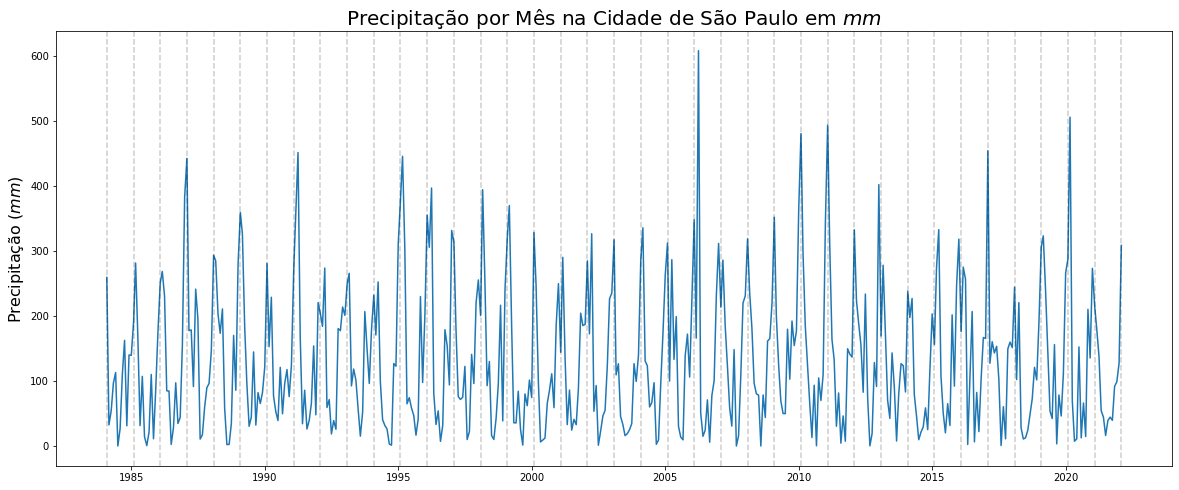

In [12]:
plot_series(rainfall) #Traça o gráfico da séries como ela é, sem transforamação.

In [13]:
stationarity_check(rainfall)

Estatísticas ADF : -4.506001282637859
p-valor: 0.0001917879351290753
Valores Críticos:

1%: -3.4451642100030084
5%: -2.8680716196949327
10%: -2.5702491139112085


A hipótese nula é rejeitada sendo que o p-valor é menor que o nível de significância 1%, portanto, de acordo com o test ADF podemos considerar essa série como estacionária, porém, vamos analisar também pela pdarima se existe necessidade de diferenciação sazonal.


## Avaliando se Existe a Necessidade de Diverenciação Sazonal através da biblioteca pdarima

In [14]:
from pmdarima.arima import nsdiffs, ndiffs

In [15]:
nsdiffs(rainfall,12) #verificando se existe a necessidade de diferenciação para m = 12

0

## Gerando os gráficos ACF e PACF inciais

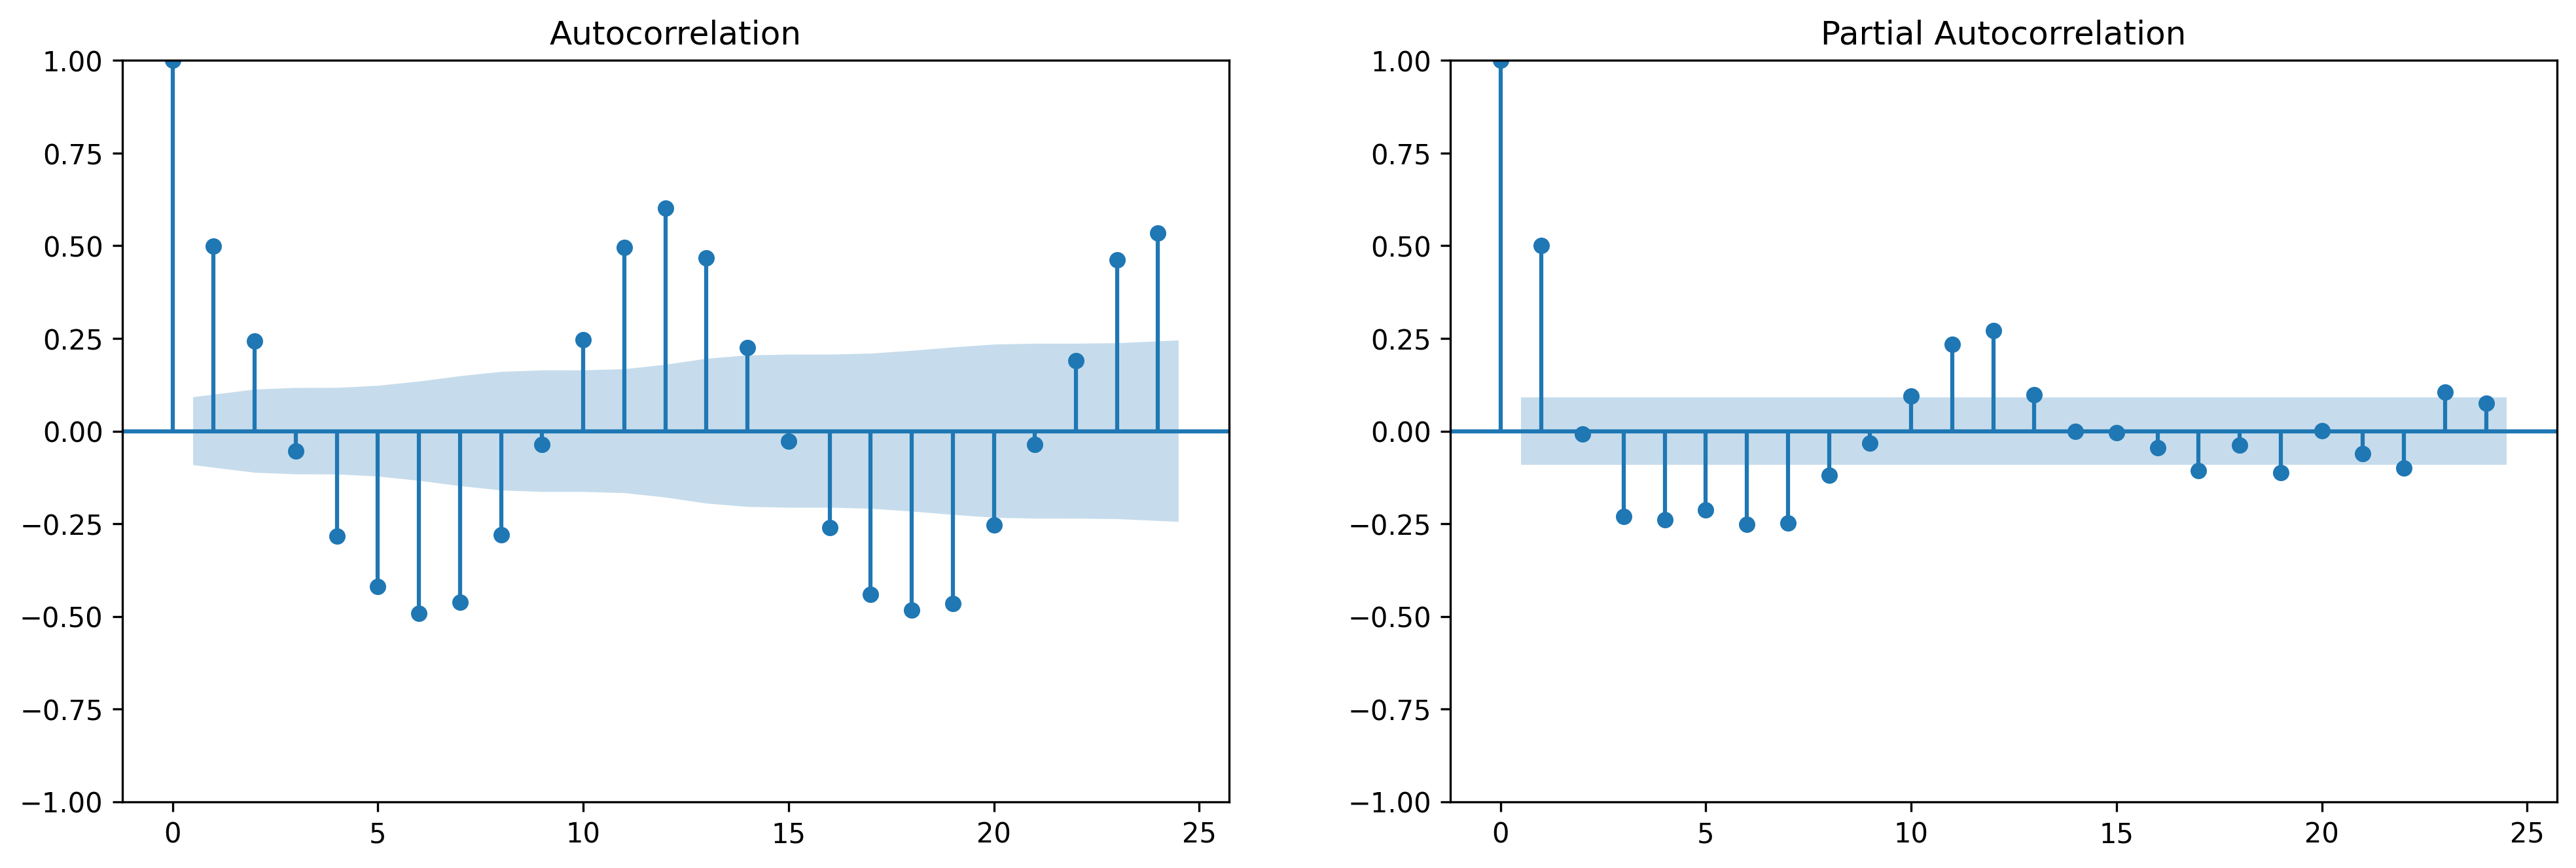

In [16]:
plot_corr(rainfall) #Traça os gráficos para ACF e PACF

## Dividindo o _dataset_ em dois diferentes conjuntos: treino e teste

O próximo passo será dividir o dataset em um cojunto de treino, que terá a maior parte do conjunto e uma parte de treino, de apenas um ano, uma vez que _forecasting_ para valores mais próximos costuma gerar resultados melhores.


In [17]:
# Treino = De 1984 até Dez/2020 e Teste de Dez/2020 até Jan/2022 
train, test = rainfall.iloc[:-14], rainfall.iloc[-15:]
x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], rainfall.shape[0]))

In [18]:
train.shape, x_train.shape, test.shape, x_test.shape

((443, 1), (443,), (15, 1), (14,))

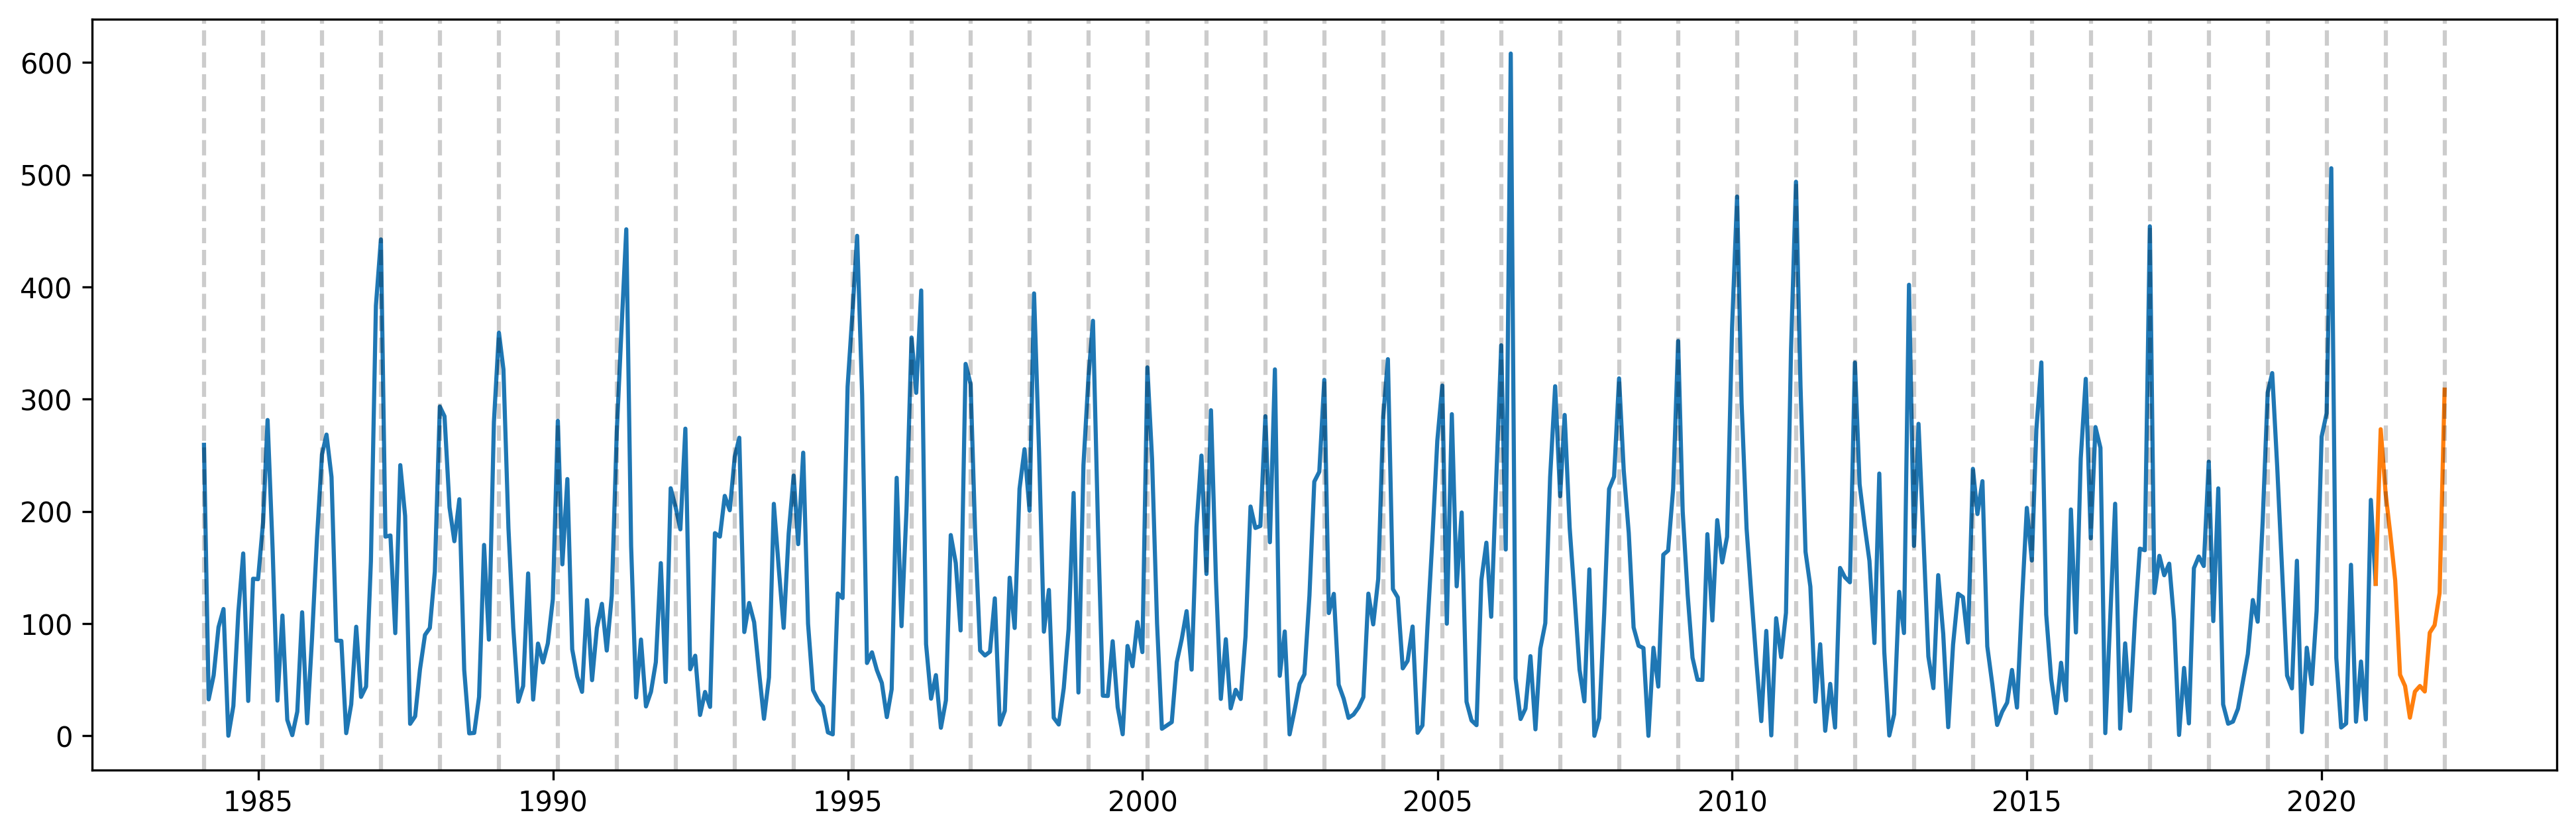

In [19]:
fig, axes = plt.subplots(1,1,figsize=(16,5), dpi= 300)
plt.plot(train)
plt.plot(test)
for year in range(start_date.year,2023):
    plt.axvline(pd.to_datetime('31-1-' + str(year)), color='k', linestyle='--', alpha=0.2)
plt.show()

### Escolha do Modelo

De acordo com o ACF e PACF, infere-se que um possível modelo com bons resultados seria:

(S)ARIMA (1, 0, 0)x(1, 0, 1)12

In [20]:
from pmdarima.arima import auto_arima

### Nessa Etapa vamos usar a função auto_arima para comparar diversos modelos possíveis e validar se o modelo escolhidos nos passos anteriores

In [21]:
model = auto_arima(train,start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=12,             
                      d=0,          
                      seasonal='TRUE',   
                      start_P=1, 
                      start_Q=1,
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.76 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5413.264, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5200.344, Time=0.59 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5247.881, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5826.462, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=5289.183, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=5173.162, Time=2.70 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=5123.387, Time=3.65 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=5086.846, Time=1.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=5234.790, Time=0.38 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=5121.878, Time=3.36 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=5225.387, Time=1.72 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=4.74 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=5087.359, Time=1.32 sec
 ARIMA(2,0,0)(1,0,1)[12] inte

In [22]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  443
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood               -2538.423
Date:                              Thu, 15 Sep 2022   AIC                           5086.846
Time:                                      17:30:55   BIC                           5107.314
Sample:                                           0   HQIC                          5094.919
                                              - 443                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.6599      1.057      1.571      0.116      -0.411       3.731
ar.L1          0.0792      0.043      1.824      0.068      -0.006       0.164
ar.S.L12       0.9837      0.010    101.723      0.000       0.965       1.003
ma.S.L12      -0.8663      0.040    -21.437      0.000      -0.946      -0.787
sigma2      5384.9262    277.593     19.399      0.000    4840.853    5928.999
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):               206.91
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             1.02
Prob(H) (two-sided):                  0.94   Kurtosis:                         5.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Visualizando o Modelo e Resultados

In [26]:
prediction, confint = model.predict(n_periods=15, return_conf_int=True)


In [27]:
dates_pred = pd.read_csv(r"C:\Users\Matheus Alves\Documents\git_tcc\time_series_precipitation\Dataset\dados_chuvas1.csv",parse_dates=[0], index_col=0, date_parser=parser)
dates_pred = dates_pred.iloc[-15:].reset_index()
#test = test.reset_index()
for i in range(0,15):
    dates_pred.at[i,'Precipitation']= prediction[i]
print("Valores Preditos\n")
print(dates_pred)
print("Valores Reais\n")
print(test)

Valores Preditos

         Date  Precipitation
0  2020-11-30     211.364881
1  2020-12-31     269.519548
2  2021-01-31     248.481509
3  2021-02-28     190.781203
4  2021-03-31      84.674843
5  2021-04-30      65.742319
6  2021-05-31      85.873506
7  2021-06-30      59.685142
8  2021-07-31      48.308450
9  2021-08-31      69.495092
10 2021-09-30     119.553714
11 2021-10-31     138.575908
12 2021-11-30     210.015522
13 2021-12-31     266.964347
14 2022-01-31     246.247578
Valores Reais

            Precipitation
Date                     
2020-11-30          135.4
2020-12-31          273.2
2021-01-31          215.5
2021-02-28          180.6
2021-03-31          138.4
2021-04-30           54.4
2021-05-31           44.4
2021-06-30           16.2
2021-07-31           39.4
2021-08-31           44.4
2021-09-30           39.5
2021-10-31           91.9
2021-11-30           98.6
2021-12-31          127.3
2022-01-31          308.5


In [28]:
cf= pd.DataFrame(confint)

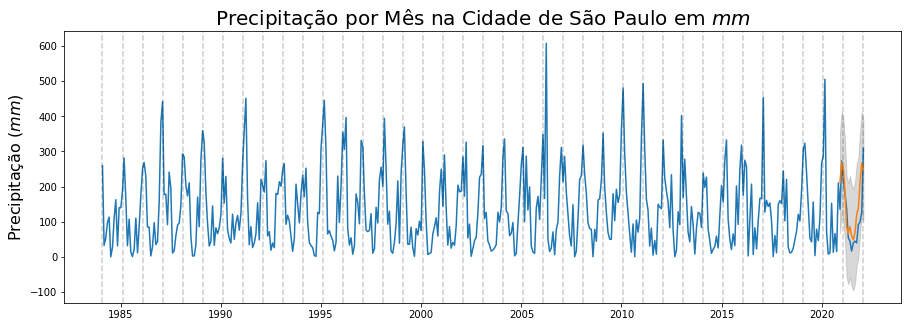

In [35]:
prediction_series = pd.Series(prediction,index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(rainfall)
ax.plot(prediction_series)
plt.title('Precipitação por Mês na Cidade de São Paulo em $mm$', fontsize=20)
plt.ylabel('Precipitação ($mm$)', fontsize=16)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)
for year in range(start_date.year,2023):
    plt.axvline(pd.to_datetime('31-1-' + str(year)), color='k', linestyle='--', alpha=0.2)
plt.show()

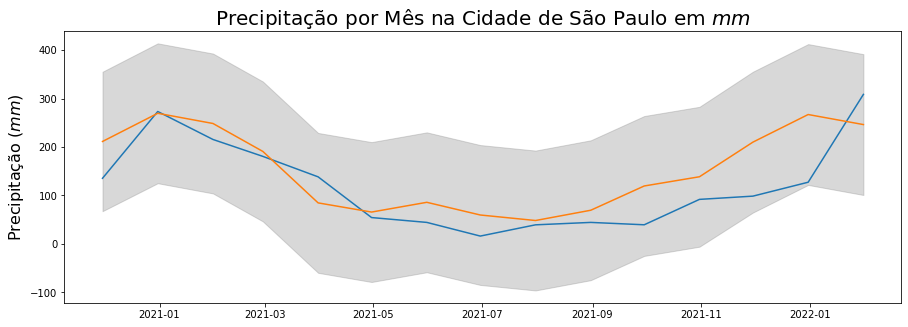

In [34]:
prediction_series = pd.Series(prediction,index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(test)
ax.plot(prediction_series)
plt.title('Precipitação por Mês na Cidade de São Paulo em $mm$', fontsize=20)
plt.ylabel('Precipitação ($mm$)', fontsize=16)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)


## Avaliando o Modelo

In [2]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

In [51]:
real_value = np.array(test['Precipitation'])
pred_value = np.array(dates_pred['Precipitation'])
t_value = np.array(train['Precipitation'])

In [52]:
smape = MeanAbsolutePercentageError(symmetric=True)
smape(real_value, pred_value)

0.45416013083029255